In [30]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [31]:
import os

path = "/content/drive/My Drive/Colab Notebooks/Final/Deep Learning"
os.chdir(path)
os.listdir(path)

['Exam - Introduction.docx',
 'Deep Learning Correction - Introduction to RNN & CNN.ipynb',
 'rice_dataset_simplified.csv',
 'Deep Learning Correction - Create & train models p.I.ipynb',
 'checkpoints',
 'Untitled0.ipynb',
 'output.xlsx',
 'output1.xlsx']

In [32]:
import numpy as np
import tensorflow as tf
=ELM
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

#data loader and preprocessing

In [33]:
# Load the dataset from the CSV file
csv_file = 'rice_dataset_simplified.csv'
df = pd.read_csv(csv_file)
df.info()
data = df.to_numpy()
print(np.shape(data))

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Columns: 2501 entries, pixel0 to Rice_type
dtypes: int64(2500), object(1)
memory usage: 95.4+ MB
(5000, 2501)


In [34]:
# Load the dataset from the CSV file
csv_file = 'rice_dataset_simplified.csv'

df = pd.read_csv(csv_file)
image_data = df.iloc[:, :-1].values  # Select all columns except the last one
# Reshape the image data to (5000, 50, 50)
images = image_data.reshape(-1, 50, 50)
labels = df.iloc[:, -1].values.reshape(-1, 1)  # Select the last column and reshape it to (5000, 1)


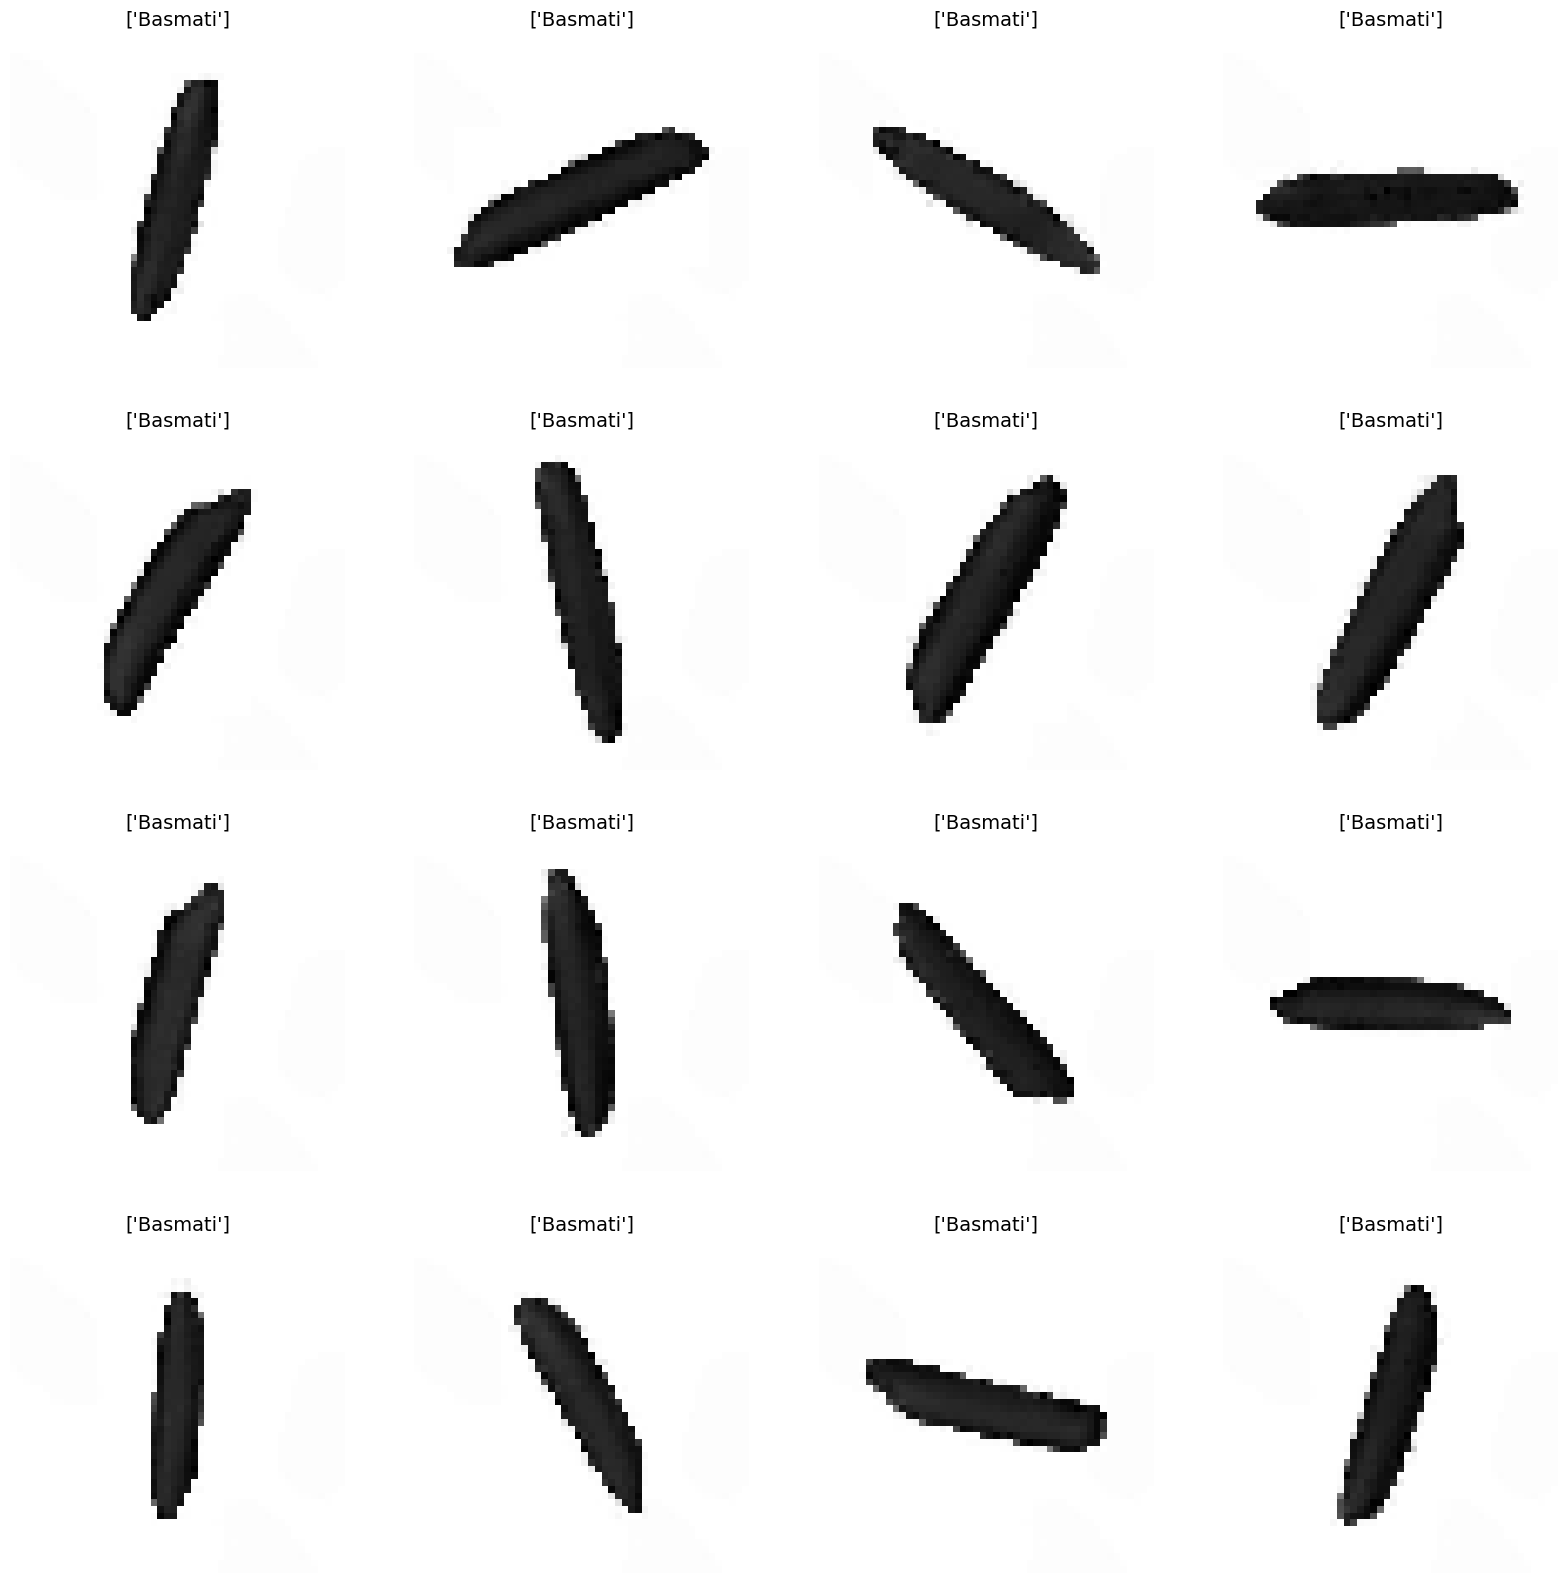

In [35]:
fig, axs = plt.subplots(4,4, figsize=(20,20))

imgs = images.astype(np.int64)


for img, label, ax in zip(imgs, labels, axs.flatten()):
    ax.imshow(img, cmap='binary')
    ax.set_title(label, fontsize=14)
    ax.axis('off')

plt.show()

In [36]:
#Preprocess
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

lbl_enc = LabelEncoder()
labels = lbl_enc.fit_transform(labels)

images = images.reshape(-1,50,50,1)

X_train, X_test, y_train, y_test = train_test_split(images/255,labels,
                                                    stratify=labels,
                                                    test_size=0.1,
                                                    random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_train,y_train,
                                                  stratify=y_train,
                                                  test_size=0.1/(1-0.3),
                                                  random_state=42)

/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_label.py:116: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [37]:
def create_dataset(images, labels, batch_size=512, shuffle=True):
    
    dataset = tf.data.Dataset.from_tensor_slices((images, labels))
    
    if shuffle:
        dataset = dataset.shuffle(buffer_size=len(images))
    
    dataset = dataset.batch(batch_size)
    dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
    
    return dataset

In [38]:
# Create the dataset from the images and labels arrays
batch_size = 1024

train_dataset = create_dataset(X_train, y_train, batch_size=batch_size)
test_dataset = create_dataset(X_test, y_test, batch_size=batch_size)
val_dataset = create_dataset(X_val, y_val, batch_size=batch_size)

In [39]:
# Assuming train_labels is a NumPy array with shape (n_samples, 1)
unique_labels, label_counts = np.unique(y_val, return_counts=True)

# Display the counts for each class
for label, count in zip(unique_labels, label_counts):
    print(f"Class {label}: {count} samples")

Class 0: 129 samples
Class 1: 128 samples
Class 2: 129 samples
Class 3: 129 samples
Class 4: 128 samples


In [40]:
#check the shape
print(np.shape(y_train))

(3857,)


##build CNN mondel

In [41]:
from tensorflow.keras import layers

# Define the CNN model architecture
# The CNN architecture with two 2D convolutional layers and one maxpooling layer allows the model to learn more detailed features by 
# stacking multiple convolutional layers before applying the max-pooling operation. 
model = tf.keras.Sequential([
    layers.Input(shape=(50, 50, 1)),  # Assuming grayscale images with shape (50, 50, 1)
    layers.Conv2D(32, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(64, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Conv2D(128, kernel_size=(3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dense(5, activation='sigmoid')  # Assuming a binary classification problem
])


In [51]:
model = tf.keras.Sequential([
    layers.Input(shape=(50, 50, 1)),
    layers.Conv2D(128, kernel_size=(3, 3), padding='same'),
    #layers.Conv2D(32, kernel_size=(3, 3), padding='same'),
    # layers.MaxPooling2D(pool_size=(2, 2)),

    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(256, activation='relu'),
    layers.Dropout(rate=0.5), 
    
    layers.Dense(5, activation='softmax')  # Assuming a multi-class classification problem with 5 classes
])

In [52]:
# Compile the model

model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=["accuracy"])


In [53]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_11 (Conv2D)          (None, 50, 50, 128)       1280      
                                                                 
 dropout_8 (Dropout)         (None, 50, 50, 128)       0         
                                                                 
 flatten_6 (Flatten)         (None, 320000)            0         
                                                                 
 dense_12 (Dense)            (None, 256)               81920256  
                                                                 
 dropout_9 (Dropout)         (None, 256)               0         
                                                                 
 dense_13 (Dense)            (None, 5)                 1285      
                                                                 
Total params: 81,922,821
Trainable params: 81,922,821


In [ ]:
import os
from tensorflow.keras.callbacks import ModelCheckpoint

# Define the directory to save the checkpoints
checkpoint_dir = './checkpoints'
os.makedirs(checkpoint_dir, exist_ok=True)

# Create a ModelCheckpoint callback to save the base model
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, 'model_epoch_{epoch:02d}.h5'),
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    verbose=1
)

# Train the model using the dataset and the checkpoint callback
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[checkpoint_callback]
)


Epoch 1/50
4/4 [==============================] - ETA: 0s - loss: 3.8799 - accuracy: 0.2992 
Epoch 1: val_loss improved from inf to 1.24084, saving model to ./checkpoints/model_epoch_01.h5
4/4 [==============================] - 86s 21s/step - loss: 3.8799 - accuracy: 0.2992 - val_loss: 1.2408 - val_accuracy: 0.5490
Epoch 2/50
4/4 [==============================] - ETA: 0s - loss: 1.1294 - accuracy: 0.6028 
Epoch 2: val_loss improved from 1.24084 to 0.63765, saving model to ./checkpoints/model_epoch_02.h5
4/4 [==============================] - 79s 20s/step - loss: 1.1294 - accuracy: 0.6028 - val_loss: 0.6376 - val_accuracy: 0.7045
Epoch 3/50
4/4 [==============================] - ETA: 0s - loss: 0.5488 - accuracy: 0.7716 
Epoch 3: val_loss improved from 0.63765 to 0.26495, saving model to ./checkpoints/model_epoch_03.h5
4/4 [==============================] - 110s 28s/step - loss: 0.5488 - accuracy: 0.7716 - val_loss: 0.2650 - val_accuracy: 0.9378
Epoch 4/50
4/4 [========================

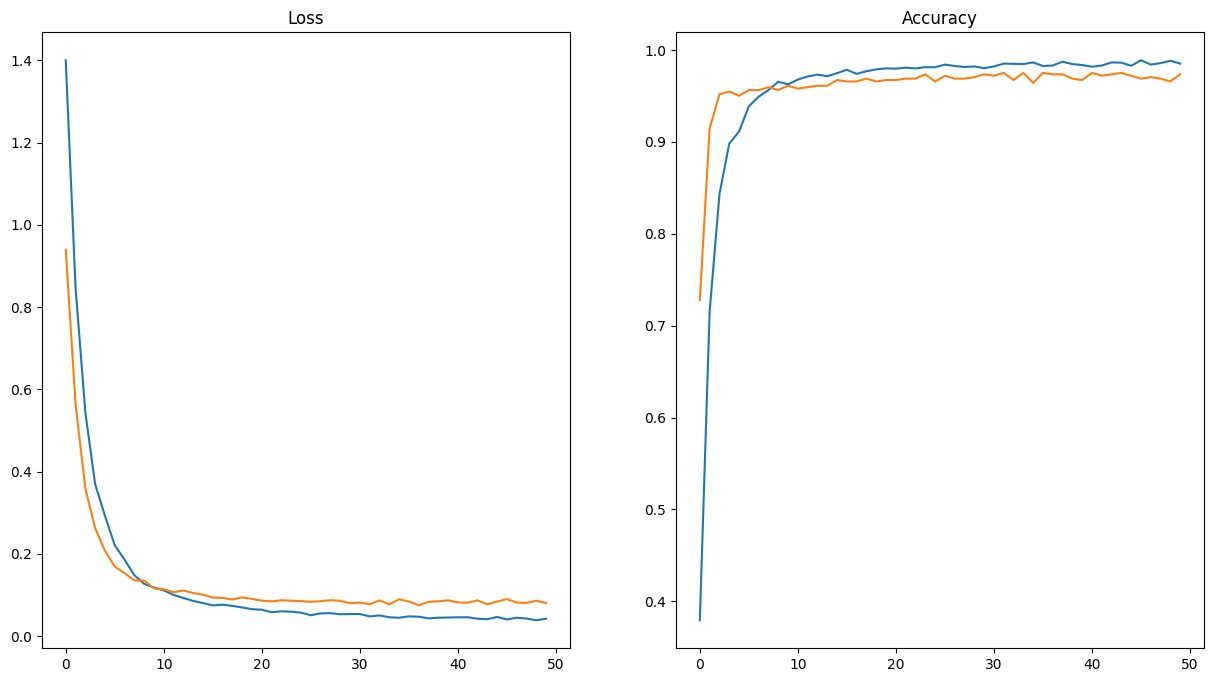

In [50]:
fig, axs = plt.subplots(1,2,figsize=(15,8))

axs[0].plot(history.history['loss'], label='loss')
axs[0].plot(history.history['val_loss'], label='val loss')
axs[0].set_title('Loss')
axs[1].plot(history.history['accuracy'], label='accuracy')
axs[1].plot(history.history['val_accuracy'], label='val accuracy')
axs[1].set_title('Accuracy')

plt.show()

In [22]:
!pip install openpyxl

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [29]:
a = np.array([history.history['loss'], history.history['val_loss'], history.history['accuracy'], history.history['val_accuracy']])
print(np.shape(a))
# Convert numpy array to pandas DataFrame
df = pd.DataFrame(a)

# Write DataFrame to .xlsx file
df.to_excel("output1.xlsx", index=False)

(4, 50)


In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 1s 60ms/step - loss: 0.0628 - accuracy: 0.9780


[0.06283534318208694, 0.9779999852180481]

In [ ]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)
print(y_pred)

16/16 [==============================] - 1s 71ms/step
[2 3 2 3 4 1 0 4 0 0 3 4 1 3 4 0 1 2 2 4 0 1 2 3 1 0 0 2 2 3 3 3 4 1 4 0 2
 1 3 1 1 4 3 0 3 3 4 3 2 4 4 3 3 0 1 4 4 0 2 3 1 1 0 3 1 2 3 0 0 2 1 3 2 0
 2 2 3 1 3 2 0 4 1 4 4 3 4 3 1 2 3 3 1 0 3 2 0 1 3 1 2 2 0 2 2 3 4 2 2 4 4
 4 3 3 1 3 2 1 2 4 0 0 0 0 1 0 3 1 2 4 1 2 1 0 0 2 0 2 4 3 1 4 2 4 3 0 4 3
 3 3 1 0 0 0 0 0 0 1 0 4 2 4 4 2 2 2 1 3 1 2 3 2 1 3 2 2 3 3 1 3 4 3 1 2 1
 0 3 2 0 4 3 2 2 2 3 2 0 4 2 4 2 3 0 2 0 3 2 2 2 1 2 1 1 0 3 1 2 3 1 3 4 2
 3 2 4 4 1 0 1 4 1 2 2 2 0 1 0 3 1 2 1 2 4 0 1 2 4 1 1 3 4 0 3 1 4 4 4 3 3
 4 1 0 0 4 3 1 4 3 1 0 4 1 3 4 2 4 1 0 1 3 2 0 0 3 4 0 4 0 4 4 3 1 1 0 4 1
 3 1 2 3 4 0 4 0 1 4 1 1 4 4 1 3 2 2 1 4 1 1 1 0 3 0 0 3 0 4 4 4 3 0 4 3 2
 3 2 0 0 2 4 2 0 0 4 4 1 0 4 0 1 1 3 2 4 4 0 4 0 1 0 0 2 2 1 3 1 1 1 0 2 4
 2 4 0 1 0 3 3 3 1 2 3 2 3 4 1 3 0 4 3 1 3 4 3 4 0 2 2 2 1 1 0 3 1 0 1 2 1
 4 2 2 1 4 4 0 0 1 0 3 2 4 1 0 3 4 1 2 2 0 4 3 2 3 4 0 0 1 1 3 3 4 2 2 4 0
 0 2 0 3 4 1 3 4 2 3 4 3 0 0 3 3 4 0 0 2 0 0 1

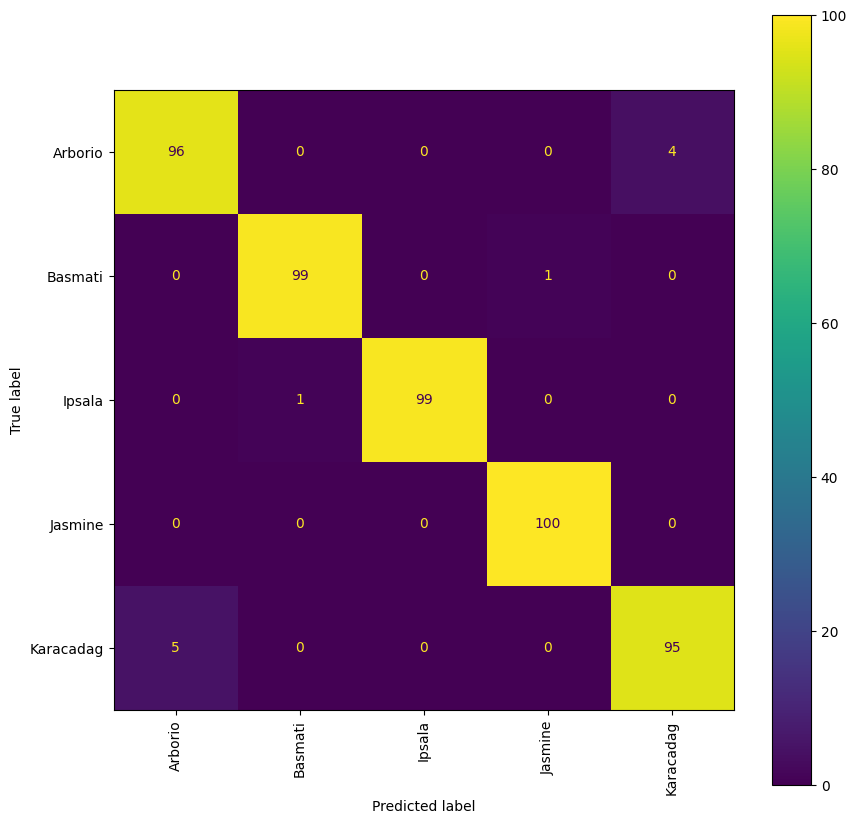

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        ax=ax,
                                        display_labels=lbl_enc.classes_,
                                        xticks_rotation='vertical')
plt.show()

#Build MLP model for comparison

In [ ]:
from tensorflow.keras import layers

tf.keras.backend.clear_session()

# Define the MLP model architecture
model = tf.keras.Sequential([
    layers.Input(shape=(50, 50, 1)),  # grayscale images with shape (50, 50, 1)
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(128, activation='relu'),
    layers.Dense(5, activation='sigmoid')  # a binary classification problem
])


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 2500)              0         
                                                                 
 dense (Dense)               (None, 64)                160064    
                                                                 
 dense_1 (Dense)             (None, 128)               8320      
                                                                 
 dense_2 (Dense)             (None, 5)                 645       
                                                                 
Total params: 169,029
Trainable params: 169,029
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# Train the model using the dataset and the checkpoint callback
epochs = 50
history = model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs
)

Epoch 1/50
4/4 [==============================] - 1s 153ms/step - loss: 1.4600 - binary_accuracy: 0.2119 - val_loss: 1.2325 - val_binary_accuracy: 0.2177
Epoch 2/50
4/4 [==============================] - 0s 74ms/step - loss: 1.1189 - binary_accuracy: 0.2145 - val_loss: 0.9368 - val_binary_accuracy: 0.2075
Epoch 3/50
4/4 [==============================] - 0s 63ms/step - loss: 0.8338 - binary_accuracy: 0.2178 - val_loss: 0.6928 - val_binary_accuracy: 0.2351
Epoch 4/50
4/4 [==============================] - 0s 64ms/step - loss: 0.6081 - binary_accuracy: 0.2371 - val_loss: 0.5060 - val_binary_accuracy: 0.2376
Epoch 5/50
4/4 [==============================] - 0s 63ms/step - loss: 0.4356 - binary_accuracy: 0.2411 - val_loss: 0.3724 - val_binary_accuracy: 0.2411
Epoch 6/50
4/4 [==============================] - 0s 68ms/step - loss: 0.3097 - binary_accuracy: 0.2437 - val_loss: 0.2766 - val_binary_accuracy: 0.2501
Epoch 7/50
4/4 [==============================] - 0s 64ms/step - loss: 0.2226 - b

In [ ]:
model.evaluate(X_test, y_test)

16/16 [==============================] - 1s 14ms/step - loss: 0.0580 - binary_accuracy: 0.2608


[0.0580013282597065, 0.26080000400543213]

In [ ]:
y_pred=model.predict(X_test)
y_pred=np.argmax(y_pred, axis=-1)
print(y_pred)

16/16 [==============================] - 0s 6ms/step
[2 3 2 3 4 1 0 4 0 0 3 4 1 3 4 0 1 2 1 4 0 1 2 3 1 0 0 1 1 3 3 3 4 1 4 0 1
 1 3 1 1 4 3 0 3 3 4 3 2 4 4 3 3 0 1 4 4 0 2 3 1 1 0 3 1 2 3 0 0 1 1 3 2 0
 2 2 3 1 3 1 0 4 1 4 4 3 4 3 1 2 3 3 1 0 3 2 0 1 3 1 2 2 0 1 2 3 4 1 1 4 4
 4 3 3 1 3 1 1 2 4 0 0 0 0 1 0 3 1 2 4 1 1 1 0 0 1 0 1 4 3 1 4 1 4 3 0 4 3
 3 3 1 0 0 0 0 0 0 1 0 4 2 4 4 1 2 2 1 3 1 2 3 2 1 3 2 2 3 3 1 3 4 3 1 2 1
 0 3 2 0 4 3 1 2 2 3 1 0 4 1 4 2 3 0 2 0 3 1 2 1 1 2 1 1 0 3 1 2 3 1 3 4 2
 3 2 4 4 1 0 1 4 1 1 1 1 0 1 0 3 1 2 1 1 4 0 1 2 4 1 1 3 4 0 3 1 4 4 4 3 3
 4 1 0 0 4 3 1 4 3 1 0 4 1 3 4 2 4 1 0 1 3 1 0 0 3 4 0 4 0 4 0 3 1 1 0 4 1
 3 1 1 3 4 0 4 0 1 4 1 1 4 4 1 3 1 1 1 4 1 1 1 0 3 0 0 3 0 4 4 4 3 0 4 3 1
 3 1 0 0 1 4 1 0 0 0 4 1 0 4 0 1 1 3 2 4 4 0 4 0 1 0 0 1 2 1 3 1 1 1 0 1 4
 1 4 0 1 0 3 3 3 1 1 3 1 3 4 1 3 0 4 3 1 3 4 3 4 0 1 2 1 1 1 0 3 1 0 1 1 1
 4 2 1 1 4 4 0 0 1 0 3 1 4 1 0 3 4 1 1 1 0 4 3 1 3 4 0 0 1 1 3 3 4 2 1 4 0
 0 1 0 3 4 1 3 4 1 1 4 3 0 0 3 3 4 0 0 2 0 0 1 

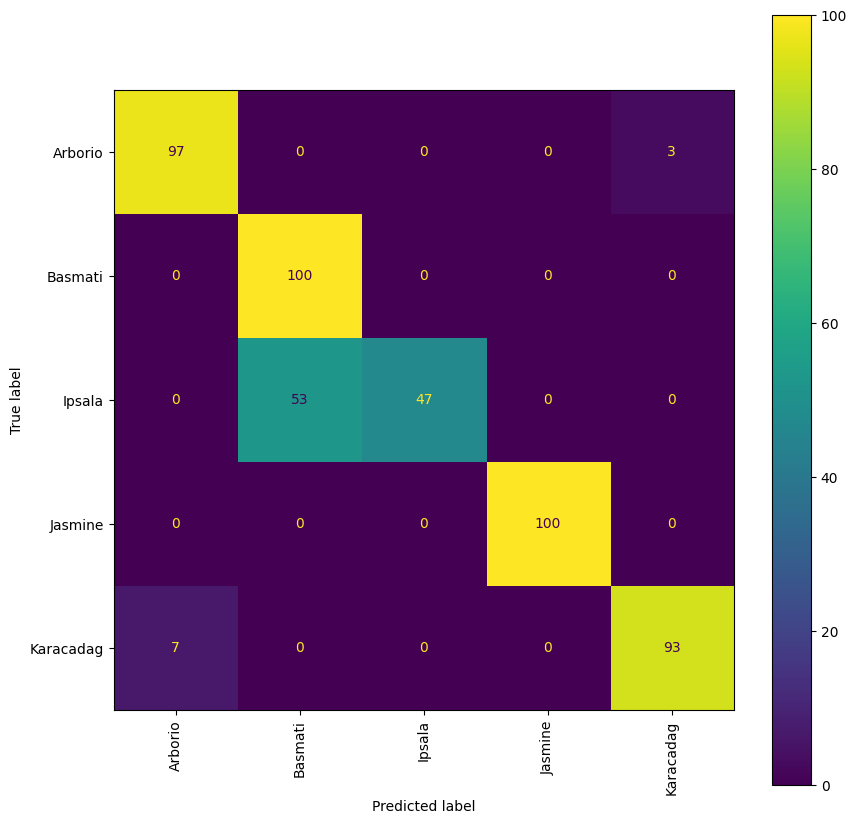

In [ ]:
from sklearn.metrics import confusion_matrix,ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred)

fig, ax = plt.subplots(figsize=(10,10))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, 
                                        ax=ax,
                                        display_labels=lbl_enc.classes_,
                                        xticks_rotation='vertical')
plt.show()